Вспомнил о том что надо делать ДЗ за пол часа до сдачи, естественно не успел сделать

In [237]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import shap
from catboost import CatBoostClassifier


from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt

%matplotlib inline

In [238]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [239]:
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

In [240]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 



In [241]:
X.to_csv (r'X.csv', index= False )
y.to_csv (r'y.csv', index= False )

Данные связаны с прямыми маркетинговыми кампаниями одного из португальских банковских учреждений. Маркетинговые кампании были основаны на телефонных звонках. Часто требовалось более одного звонка одному и томуже клиенту, чтобы понять, будет ли продукт (банковский срочный вклад) подписан ("да") или нет ("нет").

https://archive.ics.uci.edu/dataset/222/bank+marketing

In [242]:
bank_marketing.variables.to_csv (r'variables.csv', index= False )

In [243]:
train_df = X
print('Пропуск данных\n')
for col in train_df.columns:
    pct_missing = np.mean(train_df[col].isnull())
    print('{:15} - {:3}%   {}'.format(col, round(pct_missing*100), train_df[col].dtypes))

Пропуск данных

age             -   0%   int64
job             -   1%   object
marital         -   0%   object
education       -   4%   object
default         -   0%   object
balance         -   0%   int64
housing         -   0%   object
loan            -   0%   object
contact         -  29%   object
day_of_week     -   0%   int64
month           -   0%   object
duration        -   0%   int64
campaign        -   0%   int64
pdays           -   0%   int64
previous        -   0%   int64
poutcome        -  82%   object


In [244]:
X.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN


In [245]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing','loan','month'] #возьму только с небольшим пропуском данных
continuous_columns = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'previous','pdays']

In [246]:
X['job'] = X['job'].fillna('unknown')
X['education'] = X['education'].fillna('unknown')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [247]:
y = y.replace(['no', 'yes'],[0, 1])

In [248]:
df = pd.concat([
    X[categorical_columns + continuous_columns],
    y
], axis=1)

In [249]:
df.head(3)

,job,marital,education,default,housing,loan,month,age,balance,day_of_week,duration,campaign,previous,pdays,y
0,management,married,tertiary,no,yes,no,may,58,2143,5,261,1,0,-1,0
1,technician,single,secondary,no,yes,no,may,44,29,5,151,1,0,-1,0
2,entrepreneur,married,secondary,no,yes,yes,may,33,2,5,76,1,0,-1,0


In [250]:
df

,job,marital,education,default,housing,loan,month,age,balance,day_of_week,duration,campaign,previous,pdays,y
0,management,married,tertiary,no,yes,no,may,58,2143,5,261,1,0,-1,0
1,technician,single,secondary,no,yes,no,may,44,29,5,151,1,0,-1,0
2,entrepreneur,married,secondary,no,yes,yes,may,33,2,5,76,1,0,-1,0
3,blue-collar,married,unknown,no,yes,no,may,47,1506,5,92,1,0,-1,0
4,unknown,single,unknown,no,no,no,may,33,1,5,198,1,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,nov,51,825,17,977,3,0,-1,1
45207,retired,divorced,primary,no,no,no,nov,71,1729,17,456,2,0,-1,1
45208,retired,married,secondary,no,no,no,nov,72,5715,17,1127,5,3,184,1
45209,blue-collar,married,secondary,no,no,no,nov,57,668,17,508,4,0,-1,0


In [251]:
df['marital'].value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [252]:
df['marital'] = df['marital'].replace(['divorced', 'single', 'married'],[0, 0, 1])
df['loan'] = df['loan'].replace(['no', 'yes'],[0, 1])
df['housing'] = df['housing'].replace(['no', 'yes'],[0, 1])
df['default'] = df['default'].replace(['no', 'yes'],[0, 1])

In [253]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df['y'], random_state=0)

In [254]:
categorical_columns = ['job', 'education','month'] #возьму только с небольшим пропуском данных
continuous_columns = ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'previous','pdays']

In [255]:
X_train

,job,marital,education,default,housing,loan,month,age,balance,day_of_week,duration,campaign,previous,pdays
33362,services,1,secondary,0,1,0,apr,39,3870,20,72,1,0,-1
28229,management,0,tertiary,0,1,0,jan,31,1073,29,82,1,0,-1
37952,admin.,0,secondary,0,1,1,may,36,886,14,362,6,0,-1
43408,student,0,secondary,0,0,0,apr,19,394,5,327,3,0,-1
9897,housemaid,1,tertiary,0,0,0,jun,45,0,9,100,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30403,management,0,tertiary,0,0,0,feb,35,995,5,39,1,0,-1
21243,management,1,tertiary,0,1,0,aug,35,750,18,233,12,0,-1
42613,management,1,tertiary,0,0,0,jan,35,323,11,261,2,0,-1
43567,retired,1,secondary,0,0,0,apr,70,616,27,149,2,1,182


In [256]:
pd.get_dummies(X_train, prefix=categorical_columns)

,marital,default,housing,loan,age,balance,day_of_week,duration,campaign,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
33362,1,0,1,0,39,3870,20,72,1,0,...,0,0,0,0,0,0,0,0,0,0
28229,0,0,1,0,31,1073,29,82,1,0,...,0,0,1,0,0,0,0,0,0,0
37952,0,0,1,1,36,886,14,362,6,0,...,0,0,0,0,0,0,1,0,0,0
43408,0,0,0,0,19,394,5,327,3,0,...,0,0,0,0,0,0,0,0,0,0
9897,1,0,0,0,45,0,9,100,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30403,0,0,0,0,35,995,5,39,1,0,...,0,1,0,0,0,0,0,0,0,0
21243,1,0,1,0,35,750,18,233,12,0,...,0,0,0,0,0,0,0,0,0,0
42613,1,0,0,0,35,323,11,261,2,0,...,0,0,1,0,0,0,0,0,0,0
43567,1,0,0,0,70,616,27,149,2,1,...,0,0,0,0,0,0,0,0,0,0


In [257]:
#устраним дисбаланс
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(pd.get_dummies(X_train, prefix=categorical_columns), y_train)
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_tl, y_tl)

In [258]:
model = CatBoostClassifier(iterations=200, learning_rate=0.15)
model.fit(X_train, y_train)

0:	learn: 0.5750009	total: 12.5ms	remaining: 2.48s
1:	learn: 0.4897166	total: 26.2ms	remaining: 2.6s
2:	learn: 0.4373857	total: 37.9ms	remaining: 2.49s
3:	learn: 0.3476955	total: 49.3ms	remaining: 2.41s
4:	learn: 0.3210395	total: 59.8ms	remaining: 2.33s
5:	learn: 0.3006633	total: 71.4ms	remaining: 2.31s
6:	learn: 0.2846646	total: 82.6ms	remaining: 2.28s
7:	learn: 0.2719934	total: 92.7ms	remaining: 2.23s
8:	learn: 0.2632564	total: 104ms	remaining: 2.2s
9:	learn: 0.2514167	total: 115ms	remaining: 2.19s
10:	learn: 0.2439457	total: 126ms	remaining: 2.16s
11:	learn: 0.2378983	total: 137ms	remaining: 2.15s
12:	learn: 0.2328088	total: 148ms	remaining: 2.13s
13:	learn: 0.2274385	total: 159ms	remaining: 2.1s
14:	learn: 0.2197990	total: 168ms	remaining: 2.08s
15:	learn: 0.2149054	total: 178ms	remaining: 2.05s
16:	learn: 0.2102562	total: 189ms	remaining: 2.03s
17:	learn: 0.2069164	total: 200ms	remaining: 2.02s
18:	learn: 0.2028681	total: 212ms	remaining: 2.02s
19:	learn: 0.1995519	total: 223ms	re

In [259]:
y_pred = model.predict(pd.get_dummies(X_test, prefix=categorical_columns))

In [260]:
roc_auc_score(y_test,y_pred)

0.7656530404626026

In [261]:
precision_score(y_test,y_pred)

0.5738427626745041

In [262]:
recall_score(y_test,y_pred)

0.5894339622641509

In [263]:
confusion_matrix(y_test,y_pred)

array([[9398,  580],
       [ 544,  781]], dtype=int64)

In [264]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


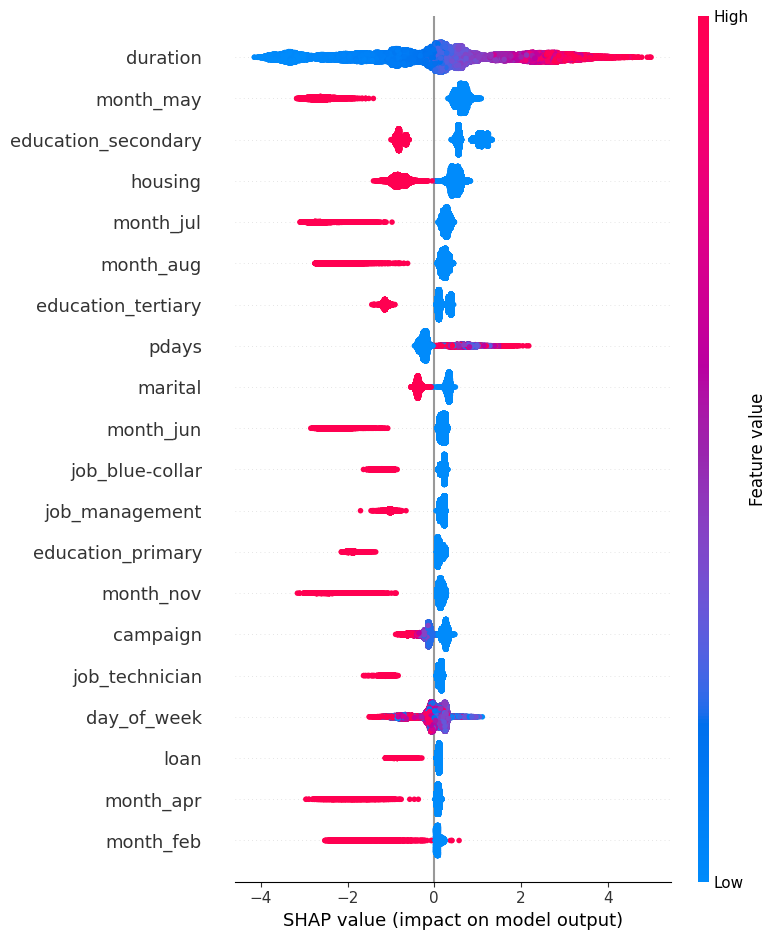

In [265]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Чем дольше шёл разговор, тем выше вероятность подписания контракт.
Люди с ипотеокой не настроенны подписания контракт.

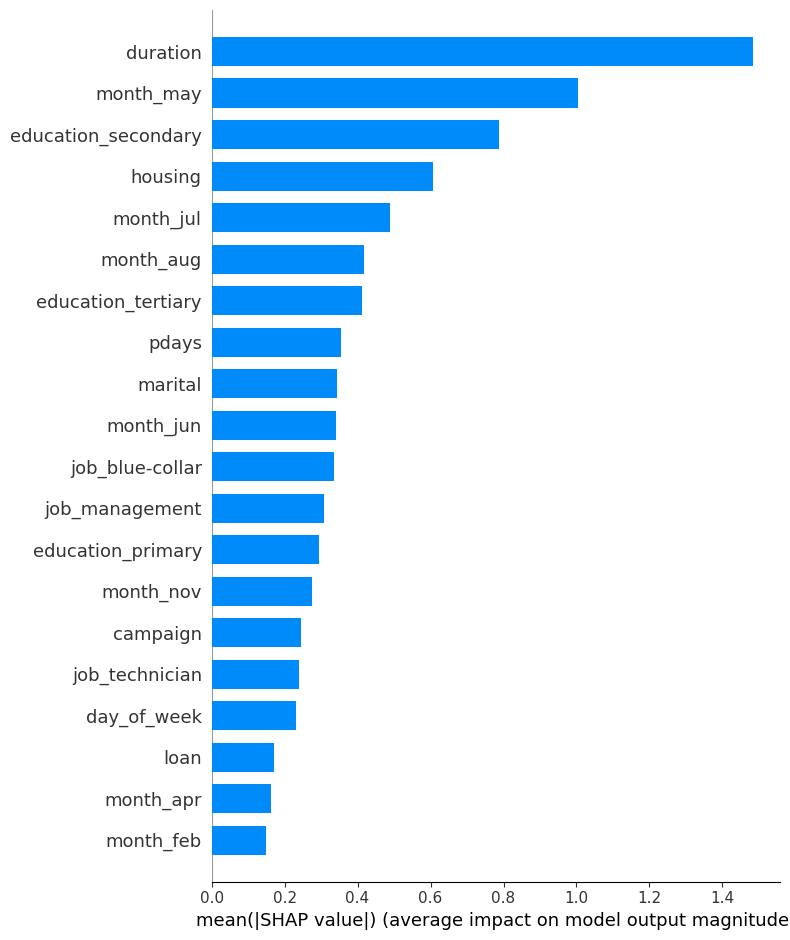

In [266]:
shap.summary_plot(shap_values, X_train, plot_type="bar")